In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold

In [104]:
k10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
var0 = VarianceThreshold(threshold=0.05)

In [105]:
col_desc = {}
cols = []
with open('datasets/Caravan_data/dictionary.txt', 'r', encoding='windows-1252') as f:
    for i,line in enumerate(f.readlines()[3:86+3]):
        words = line[2:].strip().split()
        k = words[0]
        v = ' '.join(words[1:])
        cols.append(k)
        col_desc[k] = v

In [106]:
train = pd.read_csv('datasets/Caravan_data/ticdata2000.txt', sep='\t', header=None, prefix='F_', names=cols)
val = pd.read_csv('datasets/Caravan_data/ticeval2000.txt', sep='\t', header=None, prefix='F_')
val['Target'] = pd.read_csv('datasets/Caravan_data/tictgts2000.txt', header=None)
val.columns = cols

In [107]:
data = pd.concat([train, val], axis=0)

In [108]:
train.shape, val.shape

((5822, 86), (4000, 86))

In [109]:
data.shape

(9822, 86)

In [110]:
data['MOSTYPE'].unique()

array([33, 37,  9, 40, 23, 39, 11, 10, 41, 38, 22, 13, 31, 34, 24,  8,  7,
        3, 36, 25, 20, 12, 35, 30, 29, 32,  1, 26,  2,  4, 16,  5, 21,  6,
       18, 27, 28, 17, 15, 19])

In [111]:
train_dummy = pd.concat([data.iloc[:, 1:], pd.get_dummies(data['MOSTYPE'], prefix='MOSTYPE')], axis=1)

In [112]:
train_dummy.head()

,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,...,MOSTYPE_32,MOSTYPE_33,MOSTYPE_34,MOSTYPE_35,MOSTYPE_36,MOSTYPE_37,MOSTYPE_38,MOSTYPE_39,MOSTYPE_40,MOSTYPE_41
0,1,3,2,8,0,5,1,3,7,0,...,0,1,0,0,0,0,0,0,0,0
1,1,2,2,8,1,4,1,4,6,2,...,0,0,0,0,0,1,0,0,0,0
2,1,2,2,8,0,4,2,4,3,2,...,0,0,0,0,0,1,0,0,0,0
3,1,3,3,3,2,3,2,4,5,2,...,0,0,0,0,0,0,0,0,0,0
4,1,4,2,10,1,4,1,4,7,1,...,0,0,0,0,0,0,0,0,1,0


### Highly unbalanced Target: 

In [113]:
data['CARAVAN'].value_counts() / len(data) * 100

0    94.033802
1     5.966198
Name: CARAVAN, dtype: float64

### stratified split: 70:10:30 => train/val/test

In [114]:
train, test = train_test_split(train_dummy, test_size=.3, stratify=data['CARAVAN'])
test, val = train_test_split(test, test_size=1/3, stratify=test['CARAVAN'])

In [115]:
train.shape, test.shape, val.shape

((6875, 125), (1964, 125), (983, 125))

### similar target distribution after spliting

In [116]:
train['CARAVAN'].value_counts()/len(train)

0    0.940364
1    0.059636
Name: CARAVAN, dtype: float64

In [117]:
test['CARAVAN'].value_counts()/len(test)

0    0.940428
1    0.059572
Name: CARAVAN, dtype: float64

In [118]:
val['CARAVAN'].value_counts()/len(val)

0    0.93998
1    0.06002
Name: CARAVAN, dtype: float64

### Training models

In [119]:
X_train = train.drop('CARAVAN', axis=1)
y_train = train['CARAVAN']

X_val = val.drop('CARAVAN', axis=1)
y_val = val['CARAVAN']

X_test = test.drop('CARAVAN', axis=1)
y_test = test['CARAVAN']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6875, 124), (6875,), (983, 124), (983,), (1964, 124), (1964,))

In [120]:
rf_params = {
    'n_estimators': [200,] , 
    #'max_features': [1.,],
    'max_depth':[5, 7, None],
    #'min_samples_split': [2, 10, 20]
}

rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=k10, scoring='roc_auc', verbose=1)

In [121]:
rf.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 7, None], 'n_estimators': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [122]:
rf.best_score_, rf.best_params_

(0.74514295566033018, {'max_depth': 5, 'n_estimators': 200})

In [123]:
roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])

0.78045894783182912

### LogisticRegression

In [124]:
logit_params = {'logisticregression__C':[.1, 1, 10, 100]}
log_reg = GridSearchCV(make_pipeline(var0, LogisticRegression()), logit_params, cv=k10, scoring='roc_auc', verbose=1)

In [125]:
log_reg.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   29.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.05)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [126]:
log_reg.best_score_, log_reg.best_params_

(0.73074072235489307, {'logisticregression__C': 0.1})

In [127]:
idx_rf = np.argmax(tpr_rf - fpr_rf)
idx_rf

83

In [128]:
idx_lr = np.argmax(tpr_lr - fpr_lr)
idx_lr

106

In [129]:
print(classification_report(y_test, rf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1847
          1       0.00      0.00      0.00       117

avg / total       0.88      0.94      0.91      1964



/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [130]:
print(classification_report(y_test, rf.predict_proba(X_test)[:, 1] > thres_rf[idx_rf]))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1847
          1       0.00      0.00      0.00       117

avg / total       0.88      0.94      0.91      1964



/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [131]:
confusion_matrix(y_test, rf.predict(X_test))

array([[1847,    0],
       [ 117,    0]])

In [132]:
confusion_matrix(y_test, rf.predict_proba(X_test)[:, 1] > thres_rf[idx_rf])

array([[1847,    0],
       [ 117,    0]])

In [135]:
rf_w = clone(rf.best_estimator_)

In [136]:
rf_w = rf_w.set_params(class_weight='balanced')

In [137]:
rf_w.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Sampling Methods

In [138]:
n_up = (y_train==0).sum() - y_train.sum()

tmp = X_train.loc[y_train==1, :].sample((y_train==0).sum() - y_train.sum(), replace=True)
X_up = pd.concat([X_train, tmp], axis=0)
y_up = np.r_[y_train.values, np.ones(n_up)]

X_up.shape, y_up.shape


((12930, 124), (12930,))

In [139]:
rf_up = clone(rf.best_estimator_)
rf_up.fit(X_up, y_up)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [141]:
from imblearn.over_sampling import SMOTE

In [142]:
sm = SMOTE()

In [143]:
X_res, y_res = sm.fit_sample(X_train, y_train)

In [144]:
X_res.shape, y_res.shape

((12930, 124), (12930,))

In [145]:
pd.value_counts(y_res) / len(y_res)

1    0.5
0    0.5
dtype: float64

In [146]:
rf_smote = clone(rf.best_estimator_)
rf_smote.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [148]:
def plot_roc_auc(models, names, X, y):
    
    plt.figure(figsize=(7, 7))
    
    for clf, name in zip(models, names):
        fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:, 1])

        plt.plot(fpr, tpr, linewidth=2.5, alpha=.5, 
                 label="{}: {:.4f}".format(name, roc_auc_score(y, clf.predict_proba(X)[:, 1])))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC-AUC')
    plt.legend(loc='best')

In [150]:
SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [155]:
svc = make_pipeline(var0, StandardScaler(), SVC(class_weight='balanced'))
svc_grid = GridSearchCV(svc, {'svc__C':np.exp2(np.arange(-6, 2))}, cv=k10, scoring='roc_auc', verbose=1)

In [156]:
svc_grid.fit(X_train.astype(float), y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 19.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.05)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svc__C': array([ 0.01562,  0.03125,  0.0625 ,  0.125  ,  0.25   ,  0.5    ,
        1.     ,  2.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [157]:
svc_grid.best_score_, svc_grid.best_params_

(0.72021168353914466, {'svc__C': 0.125})

In [158]:
svc_best = clone(svc_grid.best_estimator_)

svc_best = svc_best.set_params(svc__probability=True)

In [161]:
svc_best.fit(X_train.astype(float), y_train)

Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.05)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=0.125, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

/home/pongsakorn/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


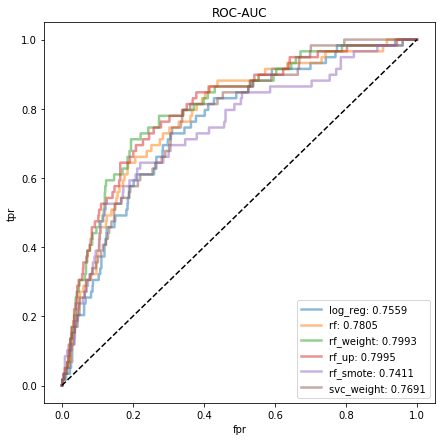

In [162]:
plot_roc_auc([log_reg, rf, rf_w, rf_up, rf_smote, svc_best], 
             ['log_reg', 'rf', 'rf_weight', 'rf_up', 'rf_smote', 'svc_weight'], 
             X_val, y_val)